In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# R-CNN

**R-CNN** использует алгоритм **[Selective Search](https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/)**, который разделяет изображение на небольшие регионы. Затем на основе похожести по цвету, текстуре, размеру и геометрическим признакам эти регионы постепенно объединяются в более крупные области. В результате получается набор регионов (обычно около 2000 на изображение), которые с высокой вероятностью могут содержать объекты. Все эти регионы приводятся к фиксированному размеру (например, 224x224) и прогоняются через заранее обученную на классификацию изображении **CNN**.

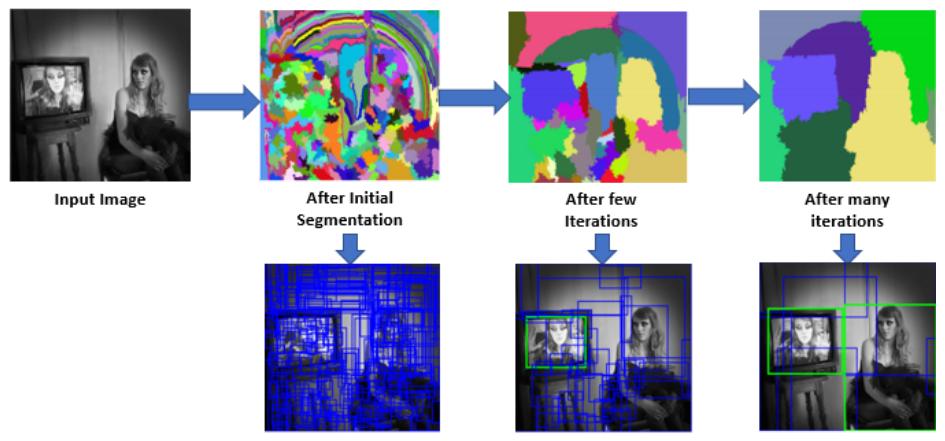

In [2]:
Image("r-cnn.png")

# [Fast R-CNN](https://en.wikipedia.org/wiki/Region_Based_Convolutional_Neural_Networks)

Недостаток R-CNN в том, что каждый найденный регион прогоняется через **CNN**, причем все эти регионы могут пересекаться между собой, что сильно увеличивает время работы этого алгоритма. Эту проблему решает **Fast R-CNN**. 

Делается это следующим образом:

- Сначала изображение прогоняется через сверточную нейросеть, получаем карту признаков на выходе нейросети.

- Запускается алгоритм **Selective Search**, который находит области с потенциально возможными объектами на них. Далее полученные боксы проецируются на карту признаков. Например, пусть нейросеть выдает на выходе изображение (карту признаков) уменьшенное в 8 раз по сравнению с исходным изображением. Тогда каждая координата боксов делится на 8, чтобы спроецировать их на карту признаков (полученные значения **округляются** в меньшую сторону, чтобы получить индексы). 

- Далее с помощью алгоритма **[Roi Pooling](https://erdem.pl/2020/02/understanding-region-of-interest-ro-i-pooling)** предложенный регион разделяется на (k, k) частей, например, 2 на 2 (тоже округляются, если получаются нецелые размеры). В полученных областях выбираются максимальные или средние значения.

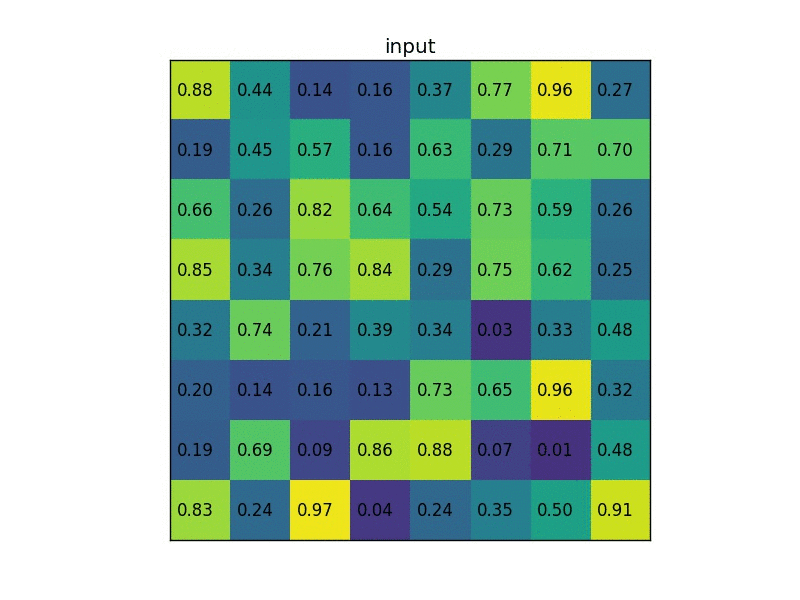

In [3]:
Image("roi_pool.gif", width=(500))

# Пример того, что значения совпадают при прогоне через нейросеть всего изображения и его части, в этом и заключается основное улучшение Fast R-CNN. В больших моделях эти значения могут различаться, но они все равно остаются хорошей аппроксимацией истинных значений.

In [4]:
X =  torch.randn((1, 6, 6)) 

In [5]:
conv = nn.Sequential( nn.Conv2d(1, 1, 3),
                      nn.ReLU(), 
                      nn.Conv2d(1, 1, 3))

In [6]:
conv(X)

tensor([[[ 0.2067,  0.4130],
         [ 0.1403, -0.0600]]], grad_fn=<SqueezeBackward1>)

In [7]:
conv(X[:, 0:5, 1:6])

tensor([[[0.4130]]], grad_fn=<SqueezeBackward1>)

# [Faster R-CNN](https://arxiv.org/pdf/1506.01497)

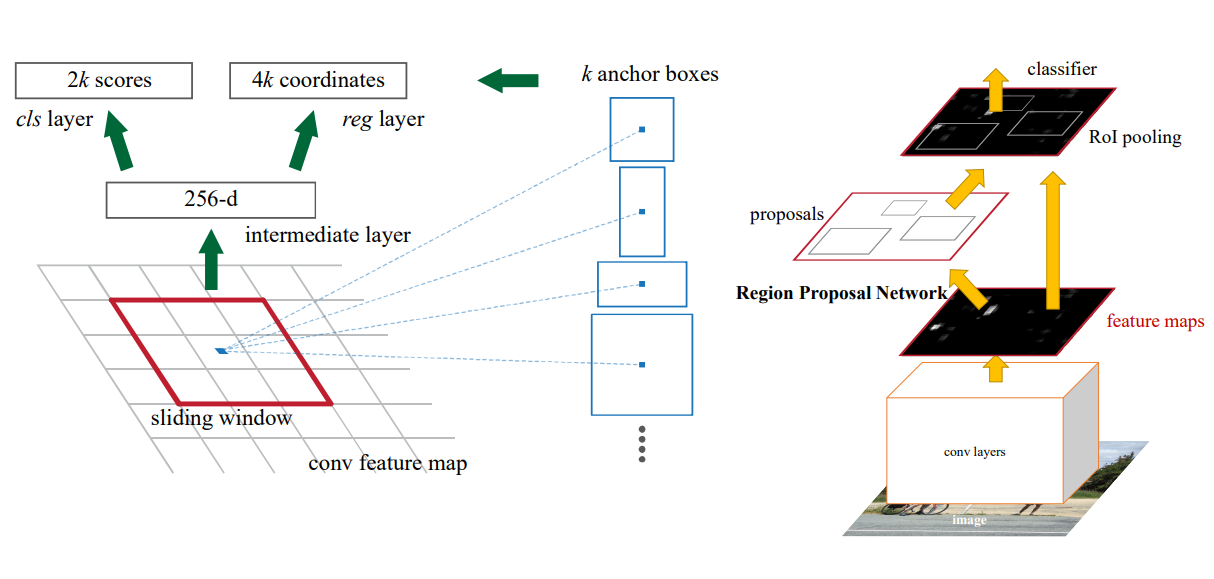

In [8]:
Image("faster_r-cnn.png")

**Fast R-CNN** стал значительно быстрее, чем **R-CNN**, но все равно оставался достаточно медленным, чтобы использовать в реальных задачах. Теперь основные вычислительные ресурсы тратились на алгоритм **Selective Search**. Таким образом появился **Faster R-CNN**, который вместо этого алгоритма использует сверточную нейросеть, которая учится определять, в определенной области находится объект или фон.

### Алгоритм Faster R-CNN во время тренировки:

1. Исходный батч изображении прогоняется через сверточную нейросеть (**backbone**). Получаем карту признаков на выходе. Размер этой карты признаков получается уменьшенной по сравнению с размерами исходного изображения (**spatial_scale** отвечает за то, во сколько раз уменьшен размер).

---

2. Часть **RPN**. Проходимся по карте признаков сверткой 3 на 3 для извлечения пространственной информации. Далее есть 2 свертки 1 на 1. Одна предсказывает 2 значения (логиты) о том, находится объект в этой области или в ней находится фон. Другая предсказывает 4 смещения прямоугольной области на изображении (**dx**, **dy**, **dw**, **dh**), где потенциально может быть объект. 
    
    Смещения (**dx**, **dy**, **dw**, **dh**) для **RPN** имеют вид:
    
    - $dx=\frac{x_{gt}\,-x_a}{w_a}; \quad dy=\frac{y_{gt}\,-y_a}{h_a};\quad$ где $x_{gt}, y_{gt}$ - координаты центра истинного бокса (таргет). $x_a, y_a$ - координаты центра якоря. 
    
    - $dw=\ln\left(\frac{w_{gt}}{w_a}\right); \quad dh=\ln\left(\frac{h_{gt}}{h_a}\right);\quad$ где $w_{gt}, h_{gt}$ - ширина и высота истинного бокса (ground truth). $w_a, h_a$ - ширина и высота якоря. 
    
---
    
3. Извлечение якорей (метод **generate_anchors**). Якорь - это прямоугольная область, которая в дальнейшем может стать предложением (proposal) путем применения к ней смещений (**dx**, **dy**, **dw**, **dh**). Якорь как бы прикрепляется к ячейке карты признаков и в каждой ячейки будет свой набор таких якорей. Есть параметры **anchor_scales**, который отвечает за размеры якоря, и **anchor_ratios**, который отвечает за отношение сторон якоря. Соответственно, если **anchor_scales** = [128, 256, 512] и **anchor_ratios** = [0.5, 1.0, 2.0], то в каждой ячейке карты признаков будет по 3 * 3 = 9 якорей. Внутри этого метода вычисляется центр каждой ячейки карты признаков в координатах исходного изображения. Далее перебираются 9 всевозможных комбинации **anchor_scales** и **anchor_ratios** и для каждой создается свой якорь (anchor). На выходе получается тензор размерности [num_total_anchors, 4], где 4 - координаты левого верхнего и правого нижнего угла (**x1**, **y1**, **x2**, **y2**), а **num_total_anchors** = ширина_карты_признаков * высота_карты_признаков * 9.

# Якори в конкретной ячейке карты признаков

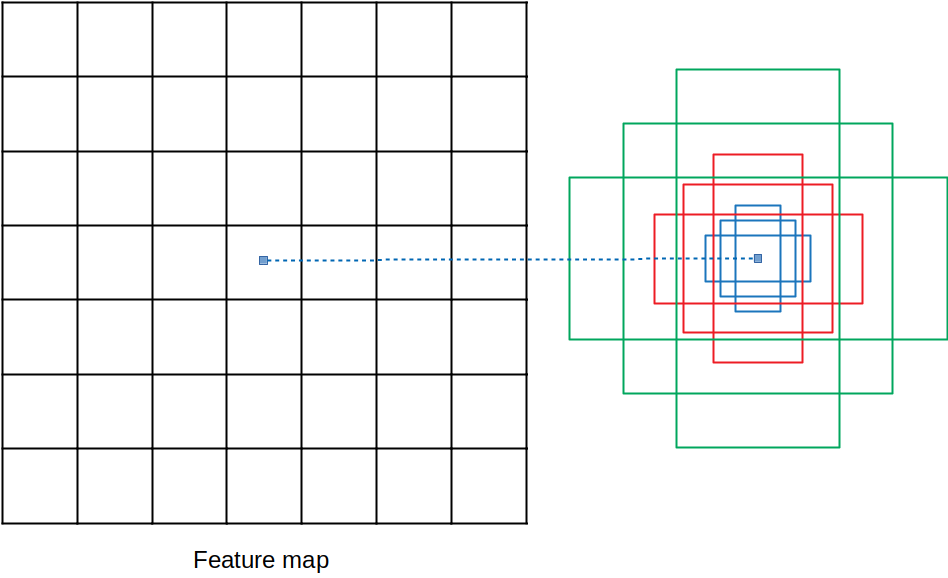

In [9]:
Image("anchors.png", width=600)

4. Вычисление потерь (Loss) в части RPN (Region Proposal Network) в методе **compute_rpn_loss**. В ней проходимся по каждому изображению в батче, для каждого такого изображения есть вычисленные ранее логиты (rpn_cls_logits) и смещения (rpn_reg_deltas), а также истинные боксы с таргета. Используя данные об истинных боксах и якорях, можно посчитать метрику **IoU** (intersection over union) или по другому это отношение пересечения 2 множеств на их объединение. Эта метрика количественно определяет перекрытие между прогнозируемым ограничивающим прямоугольником и истинным ограничивающим прямоугольником. Таким образом, для каждого якоря можно найти бокс из таргета, с которым у него максимальный **IoU** среди всех истинных боксов. Получаем вектор **max_iou**, размерность которого совпадает с размерностью вектора якорей, в котором каждое значение - максимальный **IoU** (то есть показатель того, насколько максимально этот якорь способен перекрываться с любым из истинных боксов). 

    Создаем вектор **labels**, который будет хранить метку класса для каждого якоря. Метка **labels[i]** = 1, если значение **max_iou[i]** > 0.7, **labels[i]** = 0, если значение **max_iou[i]** < 0.3, в остальных случаях метка = -1, что означает, что данный якорь не участвует в обучении модели (интуиция такая, что сильно перекрывающиеся с истинными боксами якори будут иметь положительный класс (является объектом на изображении), а плохо перекрывающиеся якори нулевой класс (является фоном на изображении), а якори, у которых перекрытие имеет средние значения, не будут иметь четкого разделения, поэтому они не участвуют в обучении). 
    
    В итоге у нас будет 2 функции потерь (Loss) для **RPN**: 
    
    - Одна будет решать задачу классификации: объект или фон в предсказанной области. Она принимает в качестве параметров логиты **rpn_cls_logits** из пункта 2 и метки **labels**, причем берутся только те объекты, у которых метка != -1. 
    
    - Другая будет решать задачу регрессии и уточнять границы якорей. Для этого берутся только те якори, у которых метка в **labels** == 1 (то есть высокая вероятность, что это потенциальный объект на изображении). Берется только метка 1, потому что нет смысла корректировать веса для якорей, которые с высокой вероятностью являются фоном. Для каждого такого якоря выбирается bounding box из таргета с максимальным с ней метрикой **IoU**. Далее с помощью полученного вектора боксов и соответствующих ему якорей считаются целевые смещения **dx**, **dy**, **dw**, **dh** (**target_deltas**) в методе **encode_boxes** (каким образом якорям нужно изменить свои координаты, чтобы приблизиться к истинным bounding box из таргета). В итоге функция потерь принимает целевые смещения **target_deltas** и предсказанные смещения **rpn_reg_deltas**. 
    
    - Посчитали 2 функции потерь, чтобы во время обратного прохода веса модели подстроились так, чтобы **RPN** как можно более точно классифицировал фон или объект на изображении и предсказывал необходимые смещения. Во время инференса модели якори будут преобразовываться с помощью этих смещении так, чтобы полученная прямоугольная область максимально правильно ограничивала объект на изображении.

---

5. Далее в методе **generate_proposals** происходит генерация предложении. Для этого логиты, полученные с помощью **RPN** переводятся в вероятности (**scores**) с помощью **softmax**, что якорь представляет собой объект на изображении. Используя эти вероятности мы оставляем только часть якорей с наибольшими вероятностями в векторе **scores**. С помощью метода **decode_boxes** к этим якорям применяются смещения **dx**, **dy**, **dw**, **dh**, сгенерированные во 2 пункте.

    Применение смещении (декодирование) к якорям по сути является обратным процессом, описанным в пункте 2:

    - **Восстановление центра:**

    $$
    \hat{x} = dx \cdot w_a + x_a, \quad \hat{y} = dy \cdot h_a + y_a.
    $$

    - **Восстановление размеров:**

    $$
    \hat{w} = \exp\,(\,dw\,) \cdot w_a, \quad \hat{h} = \exp\,(\,dh\,) \cdot h_a.
    $$

    - **Восстановление координат углов:**

    $$
    \hat{x}_1 = \hat{x} - 0.5 \cdot \hat{w}, \quad \hat{y}_1 = \hat{y} - 0.5 \cdot \hat{h},
    $$

    $$
    \hat{x}_2 = \hat{x} + 0.5 \cdot \hat{w}, \quad \hat{y}_2 = \hat{y} + 0.5 \cdot \hat{h}.
    $$

    Далее полученные боксы $(\hat{x}_1, \hat{y}_1, \hat{x}_2, \hat{y}_2)$ ограничиваем в рамках размеров изображении, так как часть боксов может выходить за его рамки. 
    
    В конце применяется алгоритм **Non maximum suppression**, чтобы убрать сильно перекрывающиеся боксы.
    
    Она работает следующим образом:
    
    - **Сортировка боксов по уверенности:** Все предсказанные боксы сортируются по их score (вероятности наличия объекта на изображении) по убыванию.
    
    - **Выбор бокса с наивысшей уверенностью:** Выбирается бокс с максимальным score. Этот бокс считается лучшим кандидатом для данного объекта.
    
    - **Удаление перекрывающихся боксов:** Все боксы, которые имеют сильное перекрытие с выбранным (определяется через **IoU**), удаляются из списка, если их **IoU** с выбранным боксом превышает заданный порог (например, 0.5 или 0.7).
    
    - **Повторение:** Из оставшихся боксов повторяют шаги 2 и 3, пока не будут обработаны все боксы.
    
    На выходе получаются индексы предложении, с помощью которых можно отобрать только неперекрывающиеся области.

# Пример того, как работает алгоритм Non maximum suppression

In [10]:
def iou_score(box1, box2):
    x1_intersect = max(box1[0], box2[0])
    y1_intersect = max(box1[1], box2[1]) 
    x2_intersect = min(box1[2], box2[2])
    y2_intersect = min(box1[3], box2[3])

    width_intersect = max(0, x2_intersect - x1_intersect) 
    height_intersect = max(0, y2_intersect - y1_intersect) 
    area_intersect = width_intersect * height_intersect

    width_box1 = box1[2] - box1[0]
    height_box1 = box1[3] - box1[1]
    area_box1 = width_box1 * height_box1

    width_box2 = box2[2] - box2[0]
    height_box2 = box2[3] - box2[1]
    area_box2 = width_box2 * height_box2

    area_union = area_box1 + area_box2 - area_intersect
    iou = area_intersect / area_union
    return iou

In [11]:
def nms(proposals, scores, nms_threshold):
    sorted_indx = scores.argsort(descending=True)
    keep = []
    suppressed = [False] * len(proposals)  
    for i in sorted_indx:
        if suppressed[i]: 
            continue

        keep.append(i)  

        for j in sorted_indx:
            if i == j or suppressed[j]: 
                continue

            iou = iou_score(proposals[i], proposals[j])
            if iou > nms_threshold:
                suppressed[j] = True  

    return keep

In [12]:
def bbox(box, color="red", ax=None):
    x = [box[0], box[0], box[2], box[2], box[0]]
    y = [box[1], box[3], box[3], box[1], box[1]]
    if ax:
        ax.plot(x, y, color=color)
    else:
        plt.plot(x, y, color=color)

In [13]:
boxes = torch.tensor([
        [100, 100, 200, 200],  # Бокс A
        [110, 110, 210, 210],  # Бокс B, сильно перекрывается с A
        [300, 300, 400, 400],  # Бокс C, далеко от A и B
        [105, 105, 205, 205]   # Бокс D, также перекрывается с A
    ])

    # Оценки для боксов
scores = torch.tensor([0.9, 0.8, 0.75, 0.7])

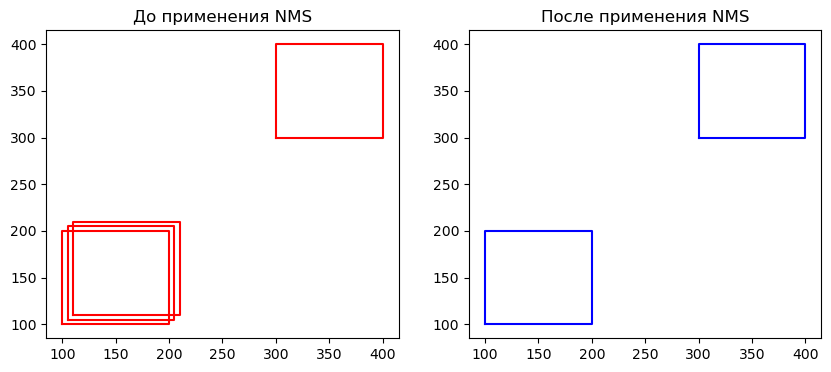

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("До применения NMS")
for box in boxes:
    bbox(box)

plt.subplot(1, 2, 2)
plt.title("После применения NMS")
for box in boxes[torch.tensor(nms(boxes, scores, 0.6))]:
    bbox(box, color="blue")

6. Предложения сгенерировали. Далее нужно получить для них метки и истинные смещения, посчитанные между предсказанными предложениями и реальными боксами, в методе **sample_rois**. Для формирования меток используется все тот же принцип **IoU**: сильно перекрывающиеся с реальными боксами предложения будут иметь класс того бокса из таргета, с которым у него наибольшее перекрытие (**IoU**). Если перекрытие слабое или его вообще нет, то класс предложения будет = 0 (фон), причем далее эти метки фильтруются так, чтобы число положительных меток и нулевых в пропорции было примерно одинаковым. 

    Далее создается тензор для хранения смещении, который в начале инициализируется нулями. Для нулевых меток он остаётся с нулевыми значениями, а для положительных будет заполнен целевыми смещениями с помощью метода **encode_boxes** (**dx**, **dy**, **dw**, **dh**, посчитанные между боксами из таргета и предложениями). То есть для слабо перекрывающихся или вообще неперекрывающихся с боксами из таргета предложении модель должна предсказывать нулевые смещения, а для сильно перекрывающихся ненулевые смещения. На выходе получаются **sampled_rois** - отобранные предложения, **labels** - метки этих предложений и **bbox_targets** - истинные смещения, посчитанные между предсказанными предложениями и реальными боксами, объединенных по батчу.
    
---

7. Далее производится операция **[Roi align](https://chao-ji.github.io/jekyll/update/2018/07/20/ROIAlign.html)** для **sampled_rois**. Она похожа на операцию **Roi pooling**, координаты прямоугольников **Roi** умножаются на коэффициент масштабирования **spatial_scale** (например, 1/8), чтобы перейти в координаты карты признаков (это похоже на то, что мы с помощью этих боксов после масштабирования отсекаем нужный нам прямоугольный кусок от карты признаков, который соответствует этому боксу), но после этого полученные координаты не округляются в меньшую сторону, как в **Roi pooling**. Каждая такая полученная область делится на (k, k) частей, например, 7 на 7. В отличие от **Roi pooling**, вместо округления координат, значения частей извлекаются как среднее или максимум значений из 4 ближайших точек на карте признаков, а значения этих точек считаются с помощью **[билинейной интерполяции](https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html)**.

    Хорошая статья про **[Roi align](https://erdem.pl/2020/02/understanding-region-of-interest-part-2-ro-i-align)**.
    
---

8. После **Roi align** получаются карты признаков формы **[S, C, pooled_height, pooled_width]** для каждого из **S** предложении (**rois**). Можно преобразовать его в форму **[S, C * pooled_height * pooled_width]** и прогнать через 2 полносвязных слоя: один отвечает за предсказание метки класса (на выходе форма **[S, num_classes]**), другой за корректировку формы (**dx**, **dy**, **dw**, **dh**) бокса (на выходе форма **[S, num_classes*4]**). Далее применяем функцию потерь кросс энтропия для предсказанного тензора с логитами и реальных меток классов **labels**. Далее используется функция потерь для регрессии. Применяем ее для истинных (целевых) смещении **bbox_targets** и предсказанных смещении. Важно понимать, что берутся только смещения с положительными метками класса (не фон) и предсказанные смещения есть для каждого класса, поэтому берутся смещения только тех классов, которые соответствуют метке класса из **labels**. 

    *(Почему не предсказывать только 4 числа для того класса, который предсказывается в labels? Объекты разных классов (например, автомобиль и человек) могут иметь разные типичные формы и пропорции. Предсказывать отдельные корректировки для каждого класса позволяет модели адаптироваться к специфике каждого класса. Если бы сеть предсказывала только 4 числа для всех ROI, ей пришлось бы находить компромисс для всех классов. Это может привести к ухудшению качества регрессии для классов с особыми геометрическими характеристиками.)*

# Алгоритм Faster R-CNN во время инференса:

Выполняются все те же пункты, кроме 4, 6 и 8. 

Вместо 6 пункта в качестве **sampled_rois** берется нулевой по индексу элемент из **proposals**, так как предполагается, что во время инференса размер батча = 1, то есть на вход каждый раз поступает одно изображение. **labels** и **bbox_targets** не нужны, так как во время инференса нет необходимости считать функции потерь.

Вместо 8 пункта сначала получаются предсказания меток класса (логиты) и корректировки форм (**dx**, **dy**, **dw**, **dh**) боксов в полносвязных слоях, как это было описано в этом пункте. Вместо вычисления функции потерь используется метод **postprocess_detections**, который на вход принимает полученные логиты, смещения, предложения и размеры изображения. С помощью логитов и функции **Softmax** получаются вероятности для каждого предложения и каждого класса. Для каждого класса кроме фона (класс 0) применяем смещения соответствующим предложениям и среди полученных боксов оставляем только те, у которых вероятность класса больше некоторого заданного порога. В конце применяется алгоритм **Non maximum suppression**, который убирает сильно перекрывающиеся боксы.

# Самописная Faster R-CNN

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import roi_align, nms, roi_pool
import torch.optim as optim
import torchvision.transforms.v2 as T
from PIL import Image
import os

In [17]:
class FasterRCNN(nn.Module):
    def __init__(self, num_classes, 
                 anchor_scales=[128, 256, 512],
                 anchor_ratios=[0.5, 1.0, 2.0],
                 rpn_batch_size=256,
                 rpn_positive_fraction=0.5,
                 roi_batch_size=128,
                 roi_positive_fraction=0.25,
                 out_channels=256,
                 spatial_scale=1/8,
                 backbone=None):
        """
        num_classes: число классов (фон имеет индекс 0)
        anchor_scales: базовые размеры якорей (в пикселях)
        anchor_ratios: соотношения сторон якорей
        rpn_batch_size, rpn_positive_fraction: параметры для сэмплирования якорей в RPN
        roi_batch_size, roi_positive_fraction: параметры для сэмплирования ROI для Fast R-CNN
        """
        super(FasterRCNN, self).__init__()
        self.num_classes = num_classes
        self.anchor_scales = anchor_scales
        self.anchor_ratios = anchor_ratios
        self.num_anchors = len(anchor_scales) * len(anchor_ratios)
        self.rpn_batch_size = rpn_batch_size  # количество якорей, выбираемых для вычисления потерь в RPN на одном изображении.
        self.rpn_positive_fraction = rpn_positive_fraction  # доля положительных якорей в выбранном батче для RPN.
        self.roi_batch_size = roi_batch_size  # количество регионов интереса (ROI), отбираемых для обработки в Fast R-CNN head.
        self.roi_positive_fraction = roi_positive_fraction  # доля положительных примеров среди выбранных ROI.

        # ---------------- Backbone ----------------
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 64, H, W]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # [B, 256, H/8, W/8]
        )
        
        if backbone:
            self.backbone = backbone 
        
        self.out_channels = out_channels  # число каналов на выходе backbone
            
        # ---------------- Region Proposal Network (RPN) ----------------
        self.rpn_conv = nn.Sequential(nn.Conv2d(self.out_channels, 256, kernel_size=3, padding=1),
                                      #nn.ReLU(),
                                      #nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                      nn.ReLU())
        # Для каждого якоря предсказываем 2 класса (object / not object)
        self.rpn_cls = nn.Conv2d(256, self.num_anchors * 2, kernel_size=1)
        # Для каждого якоря предсказываем 4 смещения (dx, dy, dw, dh)
        self.rpn_reg = nn.Conv2d(256, self.num_anchors * 4, kernel_size=1)

        # ---------------- ROI Align ----------------
        self.roi_size = (7, 7)
        # spatial_scale = (размер feature map) / (размер входного изображения)
        self.spatial_scale = spatial_scale

        # ---------------- Fast R-CNN Head ----------------
        self.fc1 = nn.Linear(self.out_channels * self.roi_size[0] * self.roi_size[1], 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        # bbox предикты – по 4 числа на каждый класс (кроме фона)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, images, targets=None):
        """
        images: тензор размера [B, 3, H, W]
        targets: список словарей для каждого изображения, например:
                 {'boxes': Tensor[N,4], 'labels': Tensor[N]}
        """
        # 1. Извлечение признаков
        features = self.backbone(images)  # [B, 128, H/8, W/8]

        # 2. RPN
        rpn_feat = self.rpn_conv(features)
        rpn_cls_logits = self.rpn_cls(rpn_feat)   
        rpn_reg_deltas = self.rpn_reg(rpn_feat)   

        # Генерируем якоря для всей карты признаков
        anchors = self.generate_anchors(features, images.shape[-2:])

        # Приведение выходов RPN в удобную для вычисления потерь форму ([B, N, 2 or 4]). Например: (2, 18, 3, 3) -> (2, 81, 2)
        batch_size = images.shape[0]
        rpn_cls_logits = rpn_cls_logits.permute(0, 2, 3, 1).reshape(batch_size, -1, 2)
        rpn_reg_deltas = rpn_reg_deltas.permute(0, 2, 3, 1).reshape(batch_size, -1, 4)

        # Если режим обучения – вычисляем потери RPN
        if self.training:
            rpn_loss_cls, rpn_loss_reg = self.compute_rpn_loss(rpn_cls_logits, rpn_reg_deltas, anchors, targets)

        # Генерация предложений (proposal) из выходов RPN. Предложения в разрешениях изображении, а не карты признаков.
        proposals = self.generate_proposals(rpn_cls_logits, rpn_reg_deltas, anchors, images.shape[-2:])  # [B, P, 4]

        if self.training:
            # sampled_rois - отобранные предложения. [S, 4]
            # labels - метки этих предложений. [S]
            # bbox_targets - истинные смещения, посчитанные между предсказанными предложениями и реальными боксами. [S, 4]
            # roi_image_indices - индексы изображений для каждого предложения. [S]
            sampled_rois, labels, bbox_targets, roi_image_indices = self.sample_rois(proposals, targets)
        else:
            # В inference используем все предложения (при batch_size=1)
            # Здесь предполагается, что proposals – список с одним элементом.
            sampled_rois = proposals[0]
            roi_image_indices = torch.zeros((sampled_rois.shape[0],), device=sampled_rois.device, dtype=torch.long)

        # ROI Align: добавляем индекс изображения к координатам ROI
        rois = torch.cat([roi_image_indices.unsqueeze(1).float(), sampled_rois], dim=1)  # [S, 5] # S = P во время инференса
        # features - [B, C, H, W]
        # rois - [N, 5]
        # output_size - [pooled_height, pooled_width]
        # spatial_scale - коэффициент, переводящий координаты из размеров исходного изображения в размеры карты признаков
        # Извлекает для каждого ROI фиксированный набор признаков размером [S, C, pooled_height, pooled_width]
        roi_pooled = roi_align(features, rois, output_size=self.roi_size, spatial_scale=self.spatial_scale)

        # 4. Fast R-CNN Head
        x = roi_pooled.view(roi_pooled.size(0), -1)  # [S, C * pooled_height * pooled_width]
        x = F.relu(self.fc1(x))                      # [S, 1024]
        x = F.relu(self.fc2(x))                      # [S, 1024]
        cls_logits = self.cls_score(x)               # [S, num_classes]
        bbox_deltas = self.bbox_pred(x)              # [S, num_classes * 4]

        if self.training:
            # Классификационная loss для RCNN
            loss_cls = F.cross_entropy(cls_logits, labels)
            # Для регрессии считаем loss только по положительным примерам (labels > 0)
            pos_inds = (labels > 0).nonzero().squeeze(1)
            if pos_inds.numel() > 0:
                # Для каждого положительного примера выбираем предсказанные дельты,
                # соответствующие классу объекта (не фон)
                bbox_preds = []
                bbox_targets_list = []
                for idx in pos_inds:
                    # bbox_deltas имеет форму [S, num_classes * 4]; для каждого ROI предсказываются 4 числа для каждого класса.
                    cls = labels[idx].item()
                    start = cls * 4
                    end = (cls + 1) * 4
                    bbox_preds.append(bbox_deltas[idx, start:end].unsqueeze(0))
                    bbox_targets_list.append(bbox_targets[idx].unsqueeze(0))
                # Списки тензоров конкатенируются вдоль первой размерности. Например, если положительных ROI оказалось 10, то:
                # bbox_preds и bbox_targets_list будут иметь форму [10, 4]
                bbox_preds = torch.cat(bbox_preds, dim=0)
                bbox_targets_list = torch.cat(bbox_targets_list, dim=0)
                loss_reg = F.smooth_l1_loss(bbox_preds, bbox_targets_list)
            else:
                # Если положительных классов не нашлось, то выдается 0
                loss_reg = torch.tensor(0.0, device=cls_logits.device)
            losses = {
                'loss_rpn_cls': rpn_loss_cls,
                'loss_rpn_reg': rpn_loss_reg,
                'loss_rcnn_cls': loss_cls,
                'loss_rcnn_reg': loss_reg,
            }
            return losses
        else:
            # Постобработка результатов Fast R-CNN в режиме inference
            detections = self.postprocess_detections(cls_logits, bbox_deltas, proposals)
            return detections

    def generate_anchors(self, features, image_size):
        """
        Генерирует якоря по всей карте признаков.
        features: тензор [B, C, H_feat, W_feat] - тензор признаков, полученных от backbone
        image_size: (H_img, W_img) - размеры исходного изображения в пикселях
        Возвращает якоря в формате [num_total_anchors, 4] в координатах исходного изображения в формате [x1, y1, x2, y2].
        """
        device = features.device
        _, _, feat_h, feat_w = features.shape
        
        # Соотношения между высотой исходного изображения и высотой карты признаков.
        stride_h = image_size[0] / feat_h  # Шаг по высоте, чтобы находить координаты центров ячеек
        stride_w = image_size[1] / feat_w  # Шаг по ширине, чтобы находить координаты центров ячеек

        anchors = []
        for i in range(feat_h):
            for j in range(feat_w):
                # координаты центра для каждой ячейки карты признаков
                center_x = j * stride_w + stride_w / 2.
                center_y = i * stride_h + stride_h / 2.
                
                # Для каждой ячейки генерируем якоря с различными размерами и соотношениями сторон:
                for scale in self.anchor_scales:
                    for ratio in self.anchor_ratios:
                        # Фиксируем площадь якоря
                        area = scale * scale
                        
                        # Формулы для ширины и высоты фиксированной площади:
                        # W * H = area; H/W = ratio => H = W * ratio
                        # W * (W * ratio) = W^2 * ratio = area
                        # W^2 = area/ratio => W = sqrt( area/ratio )
                        w = (area / ratio) ** 0.5
                        h = w * ratio
                        
                        # Добавляем координаты левого верхнего и правого нижнего угла
                        anchors.append([center_x - w/2, center_y - h/2,
                                        center_x + w/2, center_y + h/2])
        anchors = torch.tensor(anchors, device=device)
        return anchors  # [num_total_anchors, 4]

    def generate_proposals(self, rpn_cls_logits, rpn_reg_deltas, anchors, image_size,
                           pre_nms_top_n=6000, post_nms_top_n=300, nms_thresh=0.7):
        """
        rpn_cls_logits: [B, N, 2] - логиты (значения до softmax) для классификации якорей
        rpn_reg_deltas: [B, N, 4] - предсказанные смещения для каждого якоря
        anchors: [N, 4] - сгенерированный заранее набор якорей
        image_size: [H, W] - размеры исходного изображения
        pre_nms_top_n - максимальное число якорей, отбираемых до применения NMS
        post_nms_top_n - число боксов, сохраняемых после NMS
        nms_thresh - порог для алгоритма NMS
        """
        batch_size = rpn_cls_logits.shape[0]
        proposals = []
        for b in range(batch_size):
            # Переводим логиты в вероятности, что якорь представляет собой объект на изображении, а не фон.
            scores = F.softmax(rpn_cls_logits[b].clone(), dim=-1)[:, 1]  # [N]
            deltas = rpn_reg_deltas[b]  # [N, 4]

            # Определение числа якорей для дальнейшего отбора.
            topk = min(pre_nms_top_n, scores.shape[0])
            # Выбираем topk индексов тех якорей, у которых значения scores наибольшие. 
            # То есть оставляются наиболее вероятные объекты на изображении.
            topk_idx = torch.topk(scores, topk)[1]
            topk_scores = scores[topk_idx]
            topk_deltas = deltas[topk_idx]
            topk_anchors = anchors[topk_idx]

            # Декодирование боксов, предсказанные смещения topk_deltas применяются к исходным якорям topk_anchors.
            proposals_b = self.decode_boxes(topk_anchors, topk_deltas)
            # Обрезка по границам изображения, так как новые боксы могут выходить за пределы исходного изображения.
            x1 = proposals_b[:, 0].clamp(min=0, max=image_size[1])
            y1 = proposals_b[:, 1].clamp(min=0, max=image_size[0])
            x2 = proposals_b[:, 2].clamp(min=0, max=image_size[1])
            y2 = proposals_b[:, 3].clamp(min=0, max=image_size[0])
            proposals_b = torch.stack([x1, y1, x2, y2], dim=1)

            # Удаляются перекрывающиеся боксы с меньшими score.
            keep = nms(proposals_b, topk_scores, nms_thresh)
            # Если после NMS осталось слишком много боксов, мы выбираем только первые post_nms_top_n
            keep = keep[:post_nms_top_n]
            proposals.append(proposals_b[keep])
        return proposals

    def decode_boxes(self, anchors, deltas):
        """
        anchors: [N, 4] (x1, y1, x2, y2)
        deltas: [N, 4] (dx, dy, dw, dh)
        
        Преобразует якоря и смещения (deltas) в предсказанные боксы.
        """
        # Вычисление размеров и центра якорей
        widths = anchors[:, 2] - anchors[:, 0] + 1.0
        heights = anchors[:, 3] - anchors[:, 1] + 1.0
        ctr_x = anchors[:, 0] + 0.5 * widths
        ctr_y = anchors[:, 1] + 0.5 * heights

        dx = deltas[:, 0]
        dy = deltas[:, 1]
        dw = deltas[:, 2]
        dh = deltas[:, 3]

        # Вычисление обратных encode_boxes значений. 
        # Вместо (dx, dy, dw, dh) вычисляются (gt_ctr_x, gt_ctr_y, gt_widths, gt_heights)
        pred_ctr_x = dx * widths + ctr_x
        pred_ctr_y = dy * heights + ctr_y
        pred_w = torch.exp(dw) * widths
        pred_h = torch.exp(dh) * heights

        pred_boxes = torch.zeros_like(deltas)
        pred_boxes[:, 0] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3] = pred_ctr_y + 0.5 * pred_h

        return pred_boxes

    def encode_boxes(self, anchors, gt_boxes):
        """
        anchors: [N, 4] - якори, которые удовлетворяют всем условиям
        gt_boxes: [N, 4] - истинные bounding box из таргета
        
        Вычисление целевых смещений, которые указывают, каким образом якорям нужно изменить свои координаты (dx, dy, dw, dh),
        чтобы приблизиться к истинным bounding box из таргета.
        """
        # Расчёт ширины, высоты и центров якорей
        widths = anchors[:, 2] - anchors[:, 0] + 1.0
        heights = anchors[:, 3] - anchors[:, 1] + 1.0
        ctr_x = anchors[:, 0] + 0.5 * widths
        ctr_y = anchors[:, 1] + 0.5 * heights
        
        # Расчёт ширины, высоты и центров истинных bounding box из таргета
        gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0] + 1.0
        gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1] + 1.0
        gt_ctr_x = gt_boxes[:, 0] + 0.5 * gt_widths
        gt_ctr_y = gt_boxes[:, 1] + 0.5 * gt_heights
        
        # Вычисление смещения центров по x, y и масштабных изменений
        dx = (gt_ctr_x - ctr_x) / widths
        dy = (gt_ctr_y - ctr_y) / heights
        dw = torch.log(gt_widths / widths)
        dh = torch.log(gt_heights / heights)
        deltas = torch.stack((dx, dy, dw, dh), dim=1)
        return deltas

    def compute_iou(self, boxes1, boxes2):
        """
        boxes1: [N, 4]
        boxes2: [M, 4]
        
        Вычисляет IoU между двумя наборами боксов. То есть отношение площади пересечения к площади объединения.
        Возвращает тензор размера [N, M]; (i,j) элемент соответствует IoU между i-м боксом из boxes1 и j-м боксом из boxes2
        """
        N = boxes1.shape[0]
        M = boxes2.shape[0]
        boxes1 = boxes1.unsqueeze(1).expand(N, M, 4)  # Происходит расширение оси [N, 1, 4] -> [N, M, 4]
        boxes2 = boxes2.unsqueeze(0).expand(N, M, 4)  # Происходит расширение оси [1, M, 4] -> [N, M, 4]
        
        # x и y координаты левого верхнего угла для каждого бокса: [N, M]
        x1 = torch.max(boxes1[..., 0], boxes2[..., 0])
        y1 = torch.max(boxes1[..., 1], boxes2[..., 1])
        
        # x и y координаты правого нижнего угла для каждого бокса: [N, M]
        x2 = torch.min(boxes1[..., 2], boxes2[..., 2])
        y2 = torch.min(boxes1[..., 3], boxes2[..., 3])
        
        # Площади пересечений, clamp(min=0) гарантирует, что если боксы не пересекаются 
        # (то есть разность отрицательна), значение будет не меньше нуля.
        inter = (x2 - x1 + 1).clamp(min=0) * (y2 - y1 + 1).clamp(min=0)

        area1 = (boxes1[..., 2] - boxes1[..., 0] + 1) * (boxes1[..., 3] - boxes1[..., 1] + 1)
        area2 = (boxes2[..., 2] - boxes2[..., 0] + 1) * (boxes2[..., 3] - boxes2[..., 1] + 1)
        union = area1 + area2 - inter
        iou = inter / union
        return iou

    def compute_rpn_loss(self, rpn_cls_logits, rpn_reg_deltas, anchors, targets):
        """
        rpn_cls_logits: [B, N, 2]
        rpn_reg_deltas: [B, N, 4]
        anchors: [N, 4]
        targets: [{"boxes": [K, 4], "labels": [K]}] x B
        
        Для всех якорей (anchors) вычисляет показатель IoU (пересечение / объединение) c bounding box из таргета.
        Получаем матрицу размерности [N, K], где по i-ой строке i-ый якорь, по j-ому столбцу j-ый bounding box из таргета, 
        а (i, j)-му элементу из матрицы соответствует IoU между i-ым якорем и j-ым bounding box из таргета.
        Для каждой строки матрицы вычисляем максимум по этой строке. Получаем вектор (max_iou) из N элементов, в котором для 
        i-го якоря будет максимальное значение IoU со всеми bounding box из таргета. Затем создаем вектор размеронсти N, 
        в котором будем записывать метки: -1 = метка игнорируется при вычислений Loss, 0 = задний фон, 1 = некий объект 
        (foreground). Метка = 1, если IoU из max_iou > 0.7; Метка = 0, если IoU из max_iou < 0.3. Значения между 0.3 и 0.7
        не учитываются и для них метка = -1. Эти метки используются в Cross Entrop Loss. Loss считается для rpn_cls_logits
        и меток, для которых выполняется условие сверху. Далее считаем Smooth L1 Loss для корректировки смещении якорей.
        Для вычисления берутся только метки = 1, то есть якори, которые потенциально могут представлять объект на картинке.
        Каждый якорь сопоставляется с bounding box из таргета, с которым у него максимальный IoU. Получаем target_boxes, 
        i-ой строке которого соответствует некий bounding box. То есть можно думать так: берутся все якори, которые потенциально
        могут оказаться объектами на изображении и каждый такой якорь сопоставляется с bounding box, пересечение якоря с 
        которым будет максимальным. Для соответствующих якорей и bounding box из target_boxes считаются необходимые смещения
        (dx, dy, dw, dh), а потом для этих смещении и rpn_reg_deltas считается Loss.
        """
        batch_size = rpn_cls_logits.shape[0]
        all_loss_cls = []
        all_loss_reg = []
        for b in range(batch_size):
            # Получаем набор bounding box (ограничивающий прямоугольник)
            gt_boxes = targets[b]['boxes']  # [K, 4]
            # Вычисляем IoU (intersection over union) между якорями и истинными bounding boxes
            ious = self.compute_iou(anchors, gt_boxes)  # [N, K]
            # Для каждого якоря выбирается максимальное значение IoU
            max_iou, argmax_iou = ious.max(dim=1)  # [N]

            # Инициализируем метки: -1 = ignore, 0 = background, 1 = foreground
            labels = -torch.ones(anchors.shape[0], device=anchors.device, dtype=torch.long)  # [N]
            labels[max_iou < 0.3] = 0
            labels[max_iou >= 0.7] = 1
            # Гарантируем, что каждый ground truth (истинный bounding box) будет иметь хотя бы один положительный якорь
            for i in range(gt_boxes.shape[0]):
                # Выбирается индекс якоря, для которого IoU с данным ground truth равен максимальному
                inds = (ious[:, i] == ious[:, i].max()).nonzero().squeeze(1)
                labels[inds] = 1

            # Сэмплирование: выбираем фиксированное число якорей
            num_fg = int(self.rpn_batch_size * self.rpn_positive_fraction)
            # Определение индексов foreground и background якорей
            fg_inds = (labels == 1).nonzero().squeeze(1)
            bg_inds = (labels == 0).nonzero().squeeze(1)
            
            # Если количество foreground якорей больше допустимого, случайным образом выбирается 
            # избыточное число индексов, и для них метка меняется на -1
            if fg_inds.numel() > num_fg:
                disable_inds = fg_inds[torch.randperm(fg_inds.numel(), device=anchors.device)[:fg_inds.numel()-num_fg]]
                labels[disable_inds] = -1
            # Количество background якорей = rpn_batch_size - фактическое число положительных
            num_bg = self.rpn_batch_size - (labels == 1).sum().item()
            
            # Если количество background якорей больше допустимого, случайным образом выбирается 
            # избыточное число индексов, и для них метка меняется на -1
            if bg_inds.numel() > num_bg:
                disable_inds = bg_inds[torch.randperm(bg_inds.numel(), device=anchors.device)[:bg_inds.numel()-num_bg]]
                labels[disable_inds] = -1
            
            # Cross Entropy Loss для определения объект это или задний фон. Участвуют все якори с метками 0 или 1.
            valid = (labels != -1)
            loss_cls = F.cross_entropy(rpn_cls_logits[b].clone()[valid], labels[valid])
            
            # Smooth L1 Loss для корректировки рамок якорей. Участвуют все якори с метками 1.
            pos_inds = (labels == 1)
            # Проверка наличия положительных якорей
            if pos_inds.sum() > 0:
                # Для каждого положительного якоря выбирается bounding box из таргета с максимальным IoU 
                target_boxes = gt_boxes[argmax_iou[pos_inds]]
                # Вычисление целевых смещений (каким образом якорям нужно изменить свои координаты (смещения dx, dy, dw, dh),
                # чтобы приблизиться к истинным bounding box из таргета)
                target_deltas = self.encode_boxes(anchors[pos_inds], target_boxes)
                # Благодаря этому Loss предсказанные смещения будут подстраиваться под истинные
                loss_reg = F.smooth_l1_loss(rpn_reg_deltas[b][pos_inds], target_deltas)
            else:
                loss_reg = torch.tensor(0.0, device=anchors.device)
            all_loss_cls.append(loss_cls)
            all_loss_reg.append(loss_reg)
        return sum(all_loss_cls)/batch_size, sum(all_loss_reg)/batch_size

    def sample_rois(self, proposals, targets):
        """
        proposals: [B, P, 4]
        targets: [{"boxes": [K, 4], "labels": [K]}] x B
        
        Для каждого изображения:
         - объединяет предложения с gt боксов,
         - вычисляет IoU между proposals и gt,
         - присваивает метки: положительные если IoU >= 0.5, иначе фон (0),
         - сэмплирует фиксированное число ROI с заданной долей положительных примеров,
         - вычисляет истинные смещения для положительных примеров.
         
        Возвращает:
         sampled_rois_all: [S, 4]
         labels_all: [S] (целочисленные, 0 = фон, >0 – класс объекта)
         bbox_targets_all: [S, 4]
         roi_image_indices_all: [S] – индексы изображений для каждого ROI
        """
        
        sampled_rois_all = []
        labels_all = []
        bbox_targets_all = []
        roi_image_indices_all = []

        for i, props in enumerate(proposals):
            gt_boxes = targets[i]['boxes']  # [K, 4]
            gt_labels = targets[i]['labels']  # [K]
            # Объединяем proposals с gt-боксами для гарантии того, что в выборке ROI для обучения 
            # обязательно будут присутствовать положительные примеры (Примеры с IoU > 0.5).
            props = torch.cat([props, gt_boxes], dim=0)  # [P + K]
            ious = self.compute_iou(props, gt_boxes)  # [P + K, K]
            max_iou, argmax_iou = ious.max(dim=1)  # [P + K]

            # Назначаем метки: если IoU >= 0.5, то класс объекта, иначе фон (0)
            labels = torch.zeros((props.shape[0],), device=props.device, dtype=torch.long)  # [P + K]
            pos_mask = (max_iou >= 0.5)  # [P + K]
            # Если есть хотя бы одно положительное предложение (проверка через pos_mask.sum()), то для этих предложений 
            # метки устанавливаются равными меткам gt-боксов, с которыми они имеют максимальное перекрытие.
            if pos_mask.sum() > 0:
                labels[pos_mask] = gt_labels[argmax_iou[pos_mask]]

            # Сэмплируем фиксированное число ROI
            num_rois = self.roi_batch_size
            num_pos = int(num_rois * self.roi_positive_fraction)
            pos_inds = (max_iou >= 0.5).nonzero().squeeze(1)
            neg_inds = (max_iou < 0.5).nonzero().squeeze(1)
            # Если найдено больше положительных ROI, чем требуется (num_pos), то остаются только num_pos элементов.
            if pos_inds.numel() > num_pos:
                pos_inds = pos_inds[torch.randperm(pos_inds.numel(), device=props.device)[:num_pos]]
            # Если найдено больше отрицательных ROI, чем требуется, то остаются только num_rois - pos_inds.numel() элементов.
            if neg_inds.numel() > (num_rois - pos_inds.numel()):
                neg_inds = neg_inds[torch.randperm(neg_inds.numel(), device=props.device)[:(num_rois - pos_inds.numel())]]
            # Отбор ROI и меток по объединённым индексам
            inds = torch.cat([pos_inds, neg_inds])
            sampled_rois = props[inds]
            sampled_labels = labels[inds]

            # Тензор из 0 для смещении. Для отрицательных примеров он остаётся нулевым, а для положительных будет заполнен
            # целевыми смещениями. То есть для слабо перекрывающихся или вообще неперекрывающихся с боксами из таргета 
            # предложении модель должна предсказывать нулевые смещения, а для сильно перекрывающихся ненулевые смещения.
            bbox_targets = torch.zeros((sampled_rois.shape[0], 4), device=props.device)
            # Определение, какие из выбранных ROI являются положительными.
            pos_sampled = (max_iou[inds] >= 0.5)
            if pos_sampled.sum() > 0:
                bbox_targets[pos_sampled] = self.encode_boxes(
                    sampled_rois[pos_sampled],
                    gt_boxes[argmax_iou[inds][pos_sampled]]
                )
            sampled_rois_all.append(sampled_rois)
            labels_all.append(sampled_labels)
            bbox_targets_all.append(bbox_targets)
            roi_image_indices_all.append(torch.full((sampled_rois.shape[0],), i, device=props.device, dtype=torch.long))

        # Все списки объединяются в один большой тензор по измерению батчей.
        sampled_rois_all = torch.cat(sampled_rois_all, dim=0)
        labels_all = torch.cat(labels_all, dim=0)
        bbox_targets_all = torch.cat(bbox_targets_all, dim=0)
        roi_image_indices_all = torch.cat(roi_image_indices_all, dim=0)
        return sampled_rois_all, labels_all, bbox_targets_all, roi_image_indices_all

    def postprocess_detections(self, cls_logits, bbox_deltas, proposals, score_thresh=0.3, nms_thresh=0.3):
        """
        cls_logits: [P, num_classes] - тензор логитов классификации, полученный из Fast R-CNN 
        bbox_deltas: [P, num_classes * 4] - тензор предсказанных корректировок (смещений) для каждого предложения
        proposals: [1, P, 4] - набор предложений
        
        Постобработка выходов Fast R-CNN в режиме inference:
         - применение softmax к логитам,
         - декодирование боксов для каждого класса,
         - пороговая фильтрация и применение NMS для каждого класса.
         Здесь предполагается batch_size=1.
        """
        scores = F.softmax(cls_logits, dim=-1)  # [P, num_classes]
        # Для inference используем предложения первого и единственного изображения
        proposals = proposals[0]  # [P, 4]
        final_boxes = []
        final_scores = []
        final_labels = []
        # Перебираем каждый класс по очереди
        for cls in range(1, self.num_classes):  # пропускаем фон (индекс 0)
            cls_scores = scores[:, cls]  # [P]
            cls_bbox_deltas = bbox_deltas[:, cls*4:(cls+1)*4]  # [P, 4]
            boxes = self.decode_boxes(proposals, cls_bbox_deltas)  # [P, 4]
            # На основе вероятностей для текущего класса выбираются индексы ROI, у которых значение больше порога score_thresh
            keep_inds = (cls_scores > score_thresh).nonzero().squeeze(1)  
            if keep_inds.numel() == 0:
                continue
            # Выбираем только те боксы, которые прошли по порогу (высокая уверенность, что объект некоторого класса)
            boxes = boxes[keep_inds]
            cls_scores = cls_scores[keep_inds]
            # Убираем слишком сильно пересекающиеся боксы
            keep = nms(boxes, cls_scores, nms_thresh)
            final_boxes.append(boxes[keep])
            final_scores.append(cls_scores[keep])
            final_labels.append(torch.full((len(keep),), cls, device=boxes.device))
            
        # Если хотя бы для одного класса были найдены детекции, списки final_boxes, final_scores и final_labels
        # конкатенируются по первой размерности.
        if final_boxes:
            final_boxes = torch.cat(final_boxes, dim=0)
            final_scores = torch.cat(final_scores, dim=0)
            final_labels = torch.cat(final_labels, dim=0)
        else:
            final_boxes = torch.empty((0,4), device=cls_logits.device)
            final_scores = torch.empty((0,), device=cls_logits.device)
            final_labels = torch.empty((0,), dtype=torch.int64, device=cls_logits.device)
            
        return final_boxes, final_scores, final_labels


In [18]:
class MyDetectionDataset(Dataset):
    def __init__(self, transform=None, img_size=512):
        """
        image_dir: путь к папке с изображениями.
        annotations: словарь, где ключ — имя файла, значение — словарь с ключами 'boxes' и 'labels'.
                     'boxes' — список списков [x1, y1, x2, y2].
                     'labels' — список меток для каждого бокса.
        transform: преобразования для изображений.
        """
        self.img_size = img_size
        self.image_dir = 'datasets/data/train'
        df = pd.read_csv("datasets/data/bbox.csv")
        self.annotations = dict(zip(df["image"], [{"boxes": np.array(df.iloc[i, 1:]).astype(float), "labels": [0]} for i in range(len(df))]))
        self.image_files = list(self.annotations.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        w, h, _ = np.array(image).shape
        h, w = self.img_size / w, self.img_size / h
        
        if self.transform:
            image = self.transform(image)
        ann = self.annotations[img_name]
        
        boxes = torch.tensor(ann['boxes']).float()  # (N, 4)
        
        boxes[0] = boxes[0] * w
        boxes[2] = boxes[2] * w
        
        boxes[1] = boxes[1] * h
        boxes[3] = boxes[3] * h
        
        labels = torch.tensor(ann['labels']).float()     # (N,)
        target = {"boxes": boxes.unsqueeze(0), "labels": labels}
        return image, target

In [19]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

# Преобразования для изображений
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.RandomPhotometricDistort(),
    T.RandomEqualize(),
    T.RandomAdjustSharpness(4),
    T.RandomGrayscale()
])
# Создаём датасет и DataLoader
dataset = MyDetectionDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [20]:
import torchvision.models as models

In [21]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
backbone = nn.Sequential(*list(resnet.children())[:-2]).requires_grad_(False)

In [22]:
backbone[5].requires_grad_(True);
backbone[6].requires_grad_(True);
backbone[7].requires_grad_(True);

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
model = FasterRCNN(num_classes=2, 
                   out_channels=2048, 
                   backbone=backbone,
                   spatial_scale=1/32).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.5)

In [25]:
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in dataloader:
        images = torch.stack(images).to(device)
        new_targets = []
        for target in targets:
            target = {k: v.to(device) for k, v in target.items()}
            target["labels"] = (target["labels"].long() + 1)  # смещаем метку: 0 -> 1
            new_targets.append(target)

        optimizer.zero_grad()
        losses = model(images, new_targets)
        loss = losses['loss_rpn_cls'] + losses['loss_rpn_reg'] + losses['loss_rcnn_cls'] + losses['loss_rcnn_reg']
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.3f}")
    print(f"Loss_rpn_cls: {losses['loss_rpn_cls'].item():.3f}, Loss_rpn_reg: {losses['loss_rpn_reg'].item():.3f}, Loss_rcnn_cls: {losses['loss_rcnn_cls'].item():.3f}, Loss_rcnn_reg: {losses['loss_rcnn_reg'].item():.3f}")
    print("<----------------------------------------------------------------------------->")

Epoch 1/20, Loss: 72.903
Loss_rpn_cls: 0.012, Loss_rpn_reg: 0.016, Loss_rcnn_cls: 0.072, Loss_rcnn_reg: 0.007
<----------------------------------------------------------------------------->
Epoch 2/20, Loss: 28.789
Loss_rpn_cls: 0.011, Loss_rpn_reg: 0.004, Loss_rcnn_cls: 0.025, Loss_rcnn_reg: 0.002
<----------------------------------------------------------------------------->
Epoch 3/20, Loss: 22.040
Loss_rpn_cls: 0.007, Loss_rpn_reg: 0.010, Loss_rcnn_cls: 0.038, Loss_rcnn_reg: 0.014
<----------------------------------------------------------------------------->
Epoch 4/20, Loss: 16.204
Loss_rpn_cls: 0.003, Loss_rpn_reg: 0.009, Loss_rcnn_cls: 0.020, Loss_rcnn_reg: 0.011
<----------------------------------------------------------------------------->
Epoch 5/20, Loss: 14.421
Loss_rpn_cls: 0.005, Loss_rpn_reg: 0.001, Loss_rcnn_cls: 0.021, Loss_rcnn_reg: 0.002
<----------------------------------------------------------------------------->
Epoch 6/20, Loss: 12.716
Loss_rpn_cls: 0.000, Loss

In [26]:
img_indx = [24, 30, 63, 165]
transforms_base = T.Compose([T.Resize((512, 512)), 
                             T.ToImage(),
                             T.ToDtype(torch.float32, scale=True)])
file = os.listdir("datasets/data/test/")

In [27]:
imgs = [transforms_base(Image.open(f"datasets/data/test/{file[i]}").convert("RGB")) for i in img_indx]

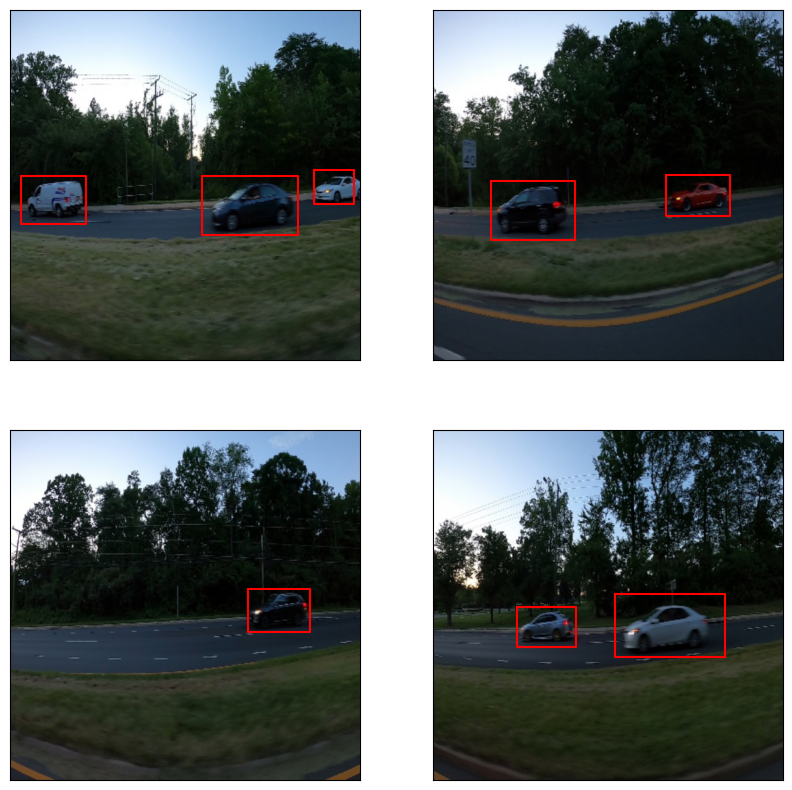

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

model = model.to("cpu")
model.eval()
for i in range(2):
    for j in range(2):
        image = imgs[i*2 + j]
        axs[i, j].imshow(image.permute(1, 2, 0))
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        
        with torch.no_grad():    
            final_boxes, final_scores, final_labels = model(image.unsqueeze(0))
            
        for box, score in zip(final_boxes, final_scores):
            if score.item() > 0.5:
                color = "red"
            elif score.item() > 0.25:
                color = "yellow"
            else:
                color = "green"
            bbox(box, color=color, ax=axs[i, j])

In [29]:
model = model.to(device)

In [26]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

In [27]:
model.eval()

# Функция для обработки кадра
def process_frame(frame):
    h_orig, w_orig = frame.shape[:2]  # Оригинальный размер кадра

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),  # Масштабируем в размер модели
        transforms.ToTensor()
    ])
    
    img = transform(frame).unsqueeze(0).to(device)  # Преобразуем изображение
    with torch.no_grad():
        final_boxes, final_scores, final_labels = model(img)
    
    # Масштабирование боксов обратно
    scale_x = w_orig / 512  # Коэффициент масштабирования по ширине
    scale_y = h_orig / 512  # Коэффициент масштабирования по высоте
    
    for box, score in zip(final_boxes, final_scores):
        if score >= 0.05:  # Порог вероятности
            x1, y1, x2, y2 = map(int, box.tolist())
            
            # Обратно масштабируем координаты
            x1, x2 = int(x1 * scale_x), int(x2 * scale_x)
            y1, y2 = int(y1 * scale_y), int(y2 * scale_y)
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Отрисовка бокса
            cv2.putText(frame, f"Score: {score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 1, cv2.LINE_AA)
    return frame

# Чтение видео
video_path = "car.mp4"
cap = cv2.VideoCapture(video_path)

# Получаем параметры видео
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Кодек и выходной файл
out = cv2.VideoWriter("out.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    processed_frame = process_frame(frame)  # Обрабатываем кадр
    out.write(processed_frame)  # Записываем результат
    cv2.imshow("Detection", processed_frame)  # Показываем результат (если работает в локальном окружении)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

In [31]:
torch.save(model.state_dict(), "model.pth")

# Реализация Faster R-CNN в PyTorch

In [20]:
def bbox(box, color="red", ax=None):
    x = [box[0], box[0], box[2], box[2], box[0]]
    y = [box[1], box[3], box[3], box[1], box[1]]
    if ax:
        ax.plot(x, y, color=color)
    else:
        plt.plot(x, y, color=color)

In [21]:
annotations = []
files = os.listdir("datasets/road_damage")

for i in range(len(files) // 2):
    image_url = files[i*2]
    txt_url = files[i*2+1]
    
    image = cv2.imread(f"datasets/road_damage/{image_url}")
    h, w = image.shape[:-1]
    bboxs = [float(value) for i, value in enumerate(open(f"datasets/road_damage/{txt_url}").read().split()) if i % 5]
    bbox_coords = []
    for i in range(len(bboxs) // 4):
        box = bboxs[i*4:(i+1)*4]
        ctr_x = box[0] * w 
        ctr_y = box[1] * h
        w_ = box[2] * w 
        h_ = box[3] * h

        bbox_coords.append([ctr_x-w_/2, ctr_y-h_/2, ctr_x+w_/2, ctr_y+h_/2])
    
    d = {"image": image_url, "boxes": bbox_coords}
    annotations.append(d)

In [22]:
import os

In [23]:
class RoadDamageDataset(Dataset):
    def __init__(self, url, annotations, transforms, scales=(0.25, 0.5)):
        """
                url: путь к папке с изображениями.
        annotations: список словарей, где каждый словарь содержит:
            'image': имя файла изображения (например, "img1.jpg")
            'boxes': список боксов в формате [[xmin, ymin, xmax, ymax], ...]
         transforms: преобразования для изображения (например, преобразование в тензор)
        """
        self.url = url
        self.annotations = annotations
        self.transforms = transforms
        self.scales = scales
        
    def __getitem__(self, idx):
        annotations = self.annotations[idx]
        image_path = os.path.join(self.url, annotations['image'])
        image = Image.open(image_path).convert("RGB")
        
        image = self.transforms(image)
            
        boxes = torch.tensor(annotations['boxes'], dtype=torch.float32)
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * self.scales[0]  
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * self.scales[1]
    
        target = {
                    "boxes": boxes,                          # Ограничивающие рамки
                    "labels": labels,                        # Метки классов
                    "image_id": torch.tensor([idx]),         # Уникальный идентификатор изображения
                    "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                    "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64)
                 }
        
        return image, target

    def __len__(self):
        return len(self.annotations)

In [24]:
transforms = T.Compose([T.Resize((540, 480)),
                        T.ToImage(),
                        T.ToDtype(torch.float32, scale=True)])

In [25]:
dataset = RoadDamageDataset(url="datasets/road_damage", 
                  annotations=annotations, 
                  transforms=transforms)

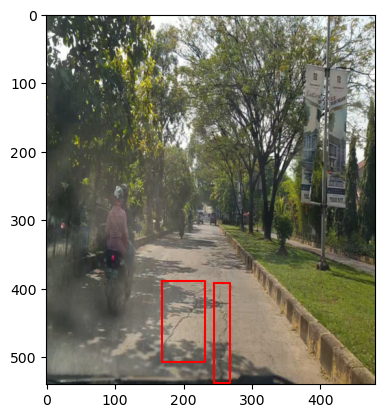

In [26]:
i = 550
plt.imshow(dataset[i][0].permute(1, 2, 0));
for box in dataset[i][1]["boxes"]:
    bbox(box);

In [27]:
def collate_fn(batch):           # Faster R-CNN модель ожидает на вход список словарей
    return tuple(zip(*batch))    # Без этого DataLoader будет "склеивать" элементы в один большой тензор

In [28]:
data_loader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

In [29]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [30]:
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [37]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

In [31]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [33]:
model.backbone.body.requires_grad_(False)
for layer in [model.backbone.body.layer3, model.backbone.body.layer4]:
    layer.requires_grad_(True)

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00005, weight_decay=1e-8)

In [35]:
num_epochs = 5

In [36]:
from tqdm import tqdm

In [37]:
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()     
        optimizer.step()      

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader):.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:10<00:00,  1.15s/it]


Epoch 1, Loss: 0.3175


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:10<00:00,  1.15s/it]


Epoch 2, Loss: 0.2719


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:08<00:00,  1.15s/it]


Epoch 3, Loss: 0.2463


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:04<00:00,  1.14s/it]


Epoch 4, Loss: 0.2182


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:01<00:00,  1.14s/it]

Epoch 5, Loss: 0.1976


In [47]:
torch.save(model.state_dict(), "model.pth")

In [39]:
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [43]:
num_epochs = 4

In [44]:
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()     
        optimizer.step()      

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader):.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:02<00:00,  1.14s/it]


Epoch 1, Loss: 0.1754


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:42<00:00,  1.18s/it]


Epoch 2, Loss: 0.1576


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [22:15<00:00,  1.21s/it]


Epoch 3, Loss: 0.1433


100%|██████████████████████████████████████████████████████████████████████████████| 1107/1107 [21:45<00:00,  1.18s/it]

Epoch 4, Loss: 0.1301


In [46]:
model.eval()

# Открываем видеофайл
video_path = "detection.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Ошибка при открытии видео")
    exit()

# Получаем параметры видео
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Определяем масштабирование для отображения (например, 50% от оригинала)
scale = 0.5
display_width = int(frame_width * scale)
display_height = int(frame_height * scale)

# Настраиваем окно для отображения
cv2.namedWindow("Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Detection", display_width, display_height)

# Создаем объект для записи обработанного видео с уменьшенным разрешением
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (display_width, display_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразуем кадр в тензор и передаем в модель
    img_tensor = transforms(frame).to(device)
    with torch.no_grad():
        predictions = model([img_tensor])

    # Рисуем предсказания на кадре
    for box, score, label in zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"]):
        if score > 0.8:  # Фильтрация по порогу уверенности
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, f"ID {label}: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Масштабируем кадр для отображения и записи
    frame_resized = cv2.resize(frame, (display_width, display_height))
    cv2.imshow("Detection", frame_resized)
    out.write(frame_resized)

    # Выход при нажатии клавиши "q"
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Освобождаем ресурсы
cap.release()
out.release()
cv2.destroyAllWindows()